# Code for Task 2.1.c and Task 2.2

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Input, BatchNormalization, Activation
import os
import matplotlib.pyplot as plt
from task2_1_a import load_data, to_categorical, common_sense_mse

2025-11-07 23:43:53.825491: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-07 23:43:53.854856: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-07 23:43:58.786126: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [4]:
BATCH_SIZE = 128
EPOCHS = 1000 # high number since we use early stopping

@tf.keras.utils.register_keras_serializable()
def common_sense_mse_12(y_true, y_pred):
    """common sense mse from task 2.1.a with num_classes = 12"""
    return common_sense_mse(y_true, y_pred, num_classes=12)

def hour_labels_to_sin_cos(y):
    """
    Convert (hour, minute) → [cos, sin] of hour angle.
    This encoding handles the circular nature of time.
    """
    hours_float = y[:, 0] + y[:, 1] / 60.0
    angle = 2 * np.pi * hours_float / 12.0  # full rotation = 12 hours
    y_cos = np.cos(angle)
    y_sin = np.sin(angle)
    return np.stack([y_cos, y_sin], axis=1)  # shape: (N, 2)

def minute_labels_to_sin_cos(y):
    """
    Convert (hour, minute) → [cos, sin] of minute angle.
    This encoding handles the circular nature of time.
    """
    minutes_float = y[:, 1]
    angle = 2 * np.pi * minutes_float / 60.0  # full rotation = 60 minutes
    y_cos = np.cos(angle)
    y_sin = np.sin(angle)
    return np.stack([y_cos, y_sin], axis=1)  # shape: (N, 2)


def build_cnn_multi_class_reg(input_shape):
    """CNN with multi-headed regression (two paths for hours and minutes)."""
    inputs = Input(shape=input_shape)
    
    # First conv block
    x1 = Conv2D(32, (3, 3), padding='same')(inputs)
    x2 = Conv2D(32, (3, 3), padding='same')(inputs)
    x1 = BatchNormalization()(x1)
    x2 = BatchNormalization()(x2)
    x1 = Activation('relu')(x1)
    x2 = Activation('relu')(x2)
    x1 = Conv2D(32, (3, 3), padding='same')(x1)
    x2 = Conv2D(32, (3, 3), padding='same')(x2)
    x1 = BatchNormalization()(x1)
    x2 = BatchNormalization()(x2)
    x1 = Activation('relu')(x1)
    x2 = Activation('relu')(x2)
    x1 = MaxPooling2D((2, 2))(x1)
    x2 = MaxPooling2D((2, 2))(x2)
    x1 = Dropout(0.2)(x1)
    x2 = Dropout(0.2)(x2)
    
    # Second conv block
    x1 = Conv2D(64, (3, 3), padding='same')(x1)
    x2 = Conv2D(64, (3, 3), padding='same')(x2)
    x1 = BatchNormalization()(x1)
    x2 = BatchNormalization()(x2)
    x1 = Activation('relu')(x1)
    x2 = Activation('relu')(x2)
    x1 = Conv2D(64, (3, 3), padding='same')(x1)
    x2 = Conv2D(64, (3, 3), padding='same')(x2)
    x1 = BatchNormalization()(x1)
    x2 = BatchNormalization()(x2)
    x1 = Activation('relu')(x1)
    x2 = Activation('relu')(x2)
    x1 = MaxPooling2D((2, 2))(x1)
    x2 = MaxPooling2D((2, 2))(x2)
    x1 = Dropout(0.2)(x1)
    x2 = Dropout(0.2)(x2)

    # Third conv block
    x1 = Conv2D(128, (3, 3), padding='same')(x1)
    x1 = BatchNormalization()(x1)
    x1 = Activation('relu')(x1)
    x1 = MaxPooling2D((2, 2))(x1)
    x1 = Dropout(0.3)(x1)

    x2 = Conv2D(128, (3, 3), padding='same')(x2)
    x2 = BatchNormalization()(x2)
    x2 = Activation('relu')(x2)
    x2 = MaxPooling2D((2, 2))(x2)
    x2 = Dropout(0.3)(x2)

    # Dense layers
    x1 = Flatten()(x1)
    x1 = Dense(128)(x1)
    x1 = BatchNormalization()(x1)
    x1 = Activation('relu')(x1)
    x1 = Dropout(0.4)(x1)

    x2 = Flatten()(x2)
    x2 = Dense(128)(x2)
    x2 = BatchNormalization()(x2)
    x2 = Activation('relu')(x2)
    x2 = Dropout(0.4)(x2)

    x1 = Flatten()(x1)
    x1 = Dense(256)(x1)
    x1 = BatchNormalization()(x1)
    x1 = Activation('relu')(x1)
    x1 = Dropout(0.4)(x1)

    x2 = Flatten()(x2)
    x2 = Dense(256)(x2)
    x2 = BatchNormalization()(x2)
    x2 = Activation('relu')(x2)
    x2 = Dropout(0.4)(x2)

    x1 = Dense(128)(x1)
    x1 = BatchNormalization()(x1)
    x1 = Activation('relu')(x1)
    x1 = Dropout(0.3)(x1)

    x2 = Dense(128)(x2)
    x2 = BatchNormalization()(x2)
    x2 = Activation('relu')(x2)
    x2 = Dropout(0.3)(x2)

    # two output layers for hours and minutes
    # hour has 12 output nodes for every hour class (0-11) with softmax activation
    hour_output = Dense(12, activation='softmax')(x1)
    minute_output = Dense(1, activation='linear')(x2)

    return keras.Model(inputs, [hour_output, minute_output], name="cnn_multi_class_regression")



def build_cnn_multi_sin_cos(input_shape):
    """CNN for periodic regression (predicting sin/cos of time angle)."""
    inputs = Input(shape=input_shape)
    
    # First conv block
    x1 = Conv2D(32, (3, 3), padding='same')(inputs)
    x2 = Conv2D(32, (3, 3), padding='same')(inputs)
    x1 = BatchNormalization()(x1)
    x2 = BatchNormalization()(x2)
    x1 = Activation('relu')(x1)
    x2 = Activation('relu')(x2)
    x1 = Conv2D(32, (3, 3), padding='same')(x1)
    x2 = Conv2D(32, (3, 3), padding='same')(x2)
    x1 = BatchNormalization()(x1)
    x2 = BatchNormalization()(x2)
    x1 = Activation('relu')(x1)
    x2 = Activation('relu')(x2)
    x1 = MaxPooling2D((2, 2))(x1)
    x2 = MaxPooling2D((2, 2))(x2)
    x1 = Dropout(0.2)(x1)
    x2 = Dropout(0.2)(x2)
    
    # Second conv block
    x1 = Conv2D(64, (3, 3), padding='same')(x1)
    x2 = Conv2D(64, (3, 3), padding='same')(x2)
    x1 = BatchNormalization()(x1)
    x2 = BatchNormalization()(x2)
    x1 = Activation('relu')(x1)
    x2 = Activation('relu')(x2)
    x1 = Conv2D(64, (3, 3), padding='same')(x1)
    x2 = Conv2D(64, (3, 3), padding='same')(x2)
    x1 = BatchNormalization()(x1)
    x2 = BatchNormalization()(x2)
    x1 = Activation('relu')(x1)
    x2 = Activation('relu')(x2)
    x1 = MaxPooling2D((2, 2))(x1)
    x2 = MaxPooling2D((2, 2))(x2)
    x1 = Dropout(0.2)(x1)
    x2 = Dropout(0.2)(x2)

    # Third conv block
    x1 = Conv2D(128, (3, 3), padding='same')(x1)
    x1 = BatchNormalization()(x1)
    x1 = Activation('relu')(x1)
    x1 = MaxPooling2D((2, 2))(x1)
    x1 = Dropout(0.3)(x1)

    x2 = Conv2D(128, (3, 3), padding='same')(x2)
    x2 = BatchNormalization()(x2)
    x2 = Activation('relu')(x2)
    x2 = MaxPooling2D((2, 2))(x2)
    x2 = Dropout(0.3)(x2)

    # Dense layers
    x1 = Flatten()(x1)
    x1 = Dense(128)(x1)
    x1 = BatchNormalization()(x1)
    x1 = Activation('relu')(x1)
    x1 = Dropout(0.4)(x1)

    x2 = Flatten()(x2)
    x2 = Dense(128)(x2)
    x2 = BatchNormalization()(x2)
    x2 = Activation('relu')(x2)
    x2 = Dropout(0.4)(x2)

    x1 = Flatten()(x1)
    x1 = Dense(256)(x1)
    x1 = BatchNormalization()(x1)
    x1 = Activation('relu')(x1)
    x1 = Dropout(0.4)(x1)

    x2 = Flatten()(x2)
    x2 = Dense(256)(x2)
    x2 = BatchNormalization()(x2)
    x2 = Activation('relu')(x2)
    x2 = Dropout(0.4)(x2)

    x1 = Dense(128)(x1)
    x1 = BatchNormalization()(x1)
    x1 = Activation('relu')(x1)
    x1 = Dropout(0.3)(x1)

    x2 = Dense(128)(x2)
    x2 = BatchNormalization()(x2)
    x2 = Activation('relu')(x2)
    x2 = Dropout(0.3)(x2)

    # Output layer: 2 nodes for cos and sin, bounded by tanh
    hours_output = Dense(12, activation='softmax')(x1)
    minutes_output = Dense(2, activation='tanh')(x2)

    return keras.Model(inputs, [hours_output, minutes_output], name="multi_cnn_periodic")

# Run experiment 2.1.c

In [ ]:
os.makedirs('saved_models', exist_ok=True)

# multi class+regression
seed=42
np.random.seed(seed)
tf.random.set_seed(seed)
keras.utils.set_random_seed(seed)

X_train, y_train, X_val, y_val, X_test, y_test, input_shape = load_data(seed=seed, easy=False)

print(X_train.shape, X_val.shape, X_test.shape)

y_train1 = to_categorical(y_train, 12)
y_val1 = to_categorical(y_val, 12)
y_test1 = to_categorical(y_test, 12)

img_rows, img_cols = X_train.shape[1], X_train.shape[2]
input_shape = (img_rows, img_cols, 1)
print(input_shape)

# regression model with two outputs
model = build_cnn_multi_class_reg(input_shape)
# compile with common sense mse for categorical hours and mse for priodic regession minutes.
model.compile(loss=[common_sense_mse_12, "mse"],
            loss_weights=[1.0, 0.5],
            optimizer=keras.optimizers.Adam(learning_rate=1e-3),
            metrics=['accuracy','accuracy'])

model.summary()

# same Callback as task 2.1.a
callbacks = [
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', patience=5, factor=0.5, verbose=1, min_lr=1e-7
    ),
    keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=15, verbose=1, restore_best_weights=True
    )
]
#  fit model
model.fit(X_train, [y_train1, y_train[:, 1]],
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        verbose=1,
        callbacks=callbacks,
        validation_data=(X_val, [y_val1, y_val[:, 1]]))
# save model
model.save('saved_models/multi_class_regression.keras')



# Run experiment 2.2

In [ ]:
# periodic regression
seed=42
np.random.seed(seed)
tf.random.set_seed(seed)
keras.utils.set_random_seed(seed)

X_train, y_train, X_val, y_val, X_test, y_test, input_shape = load_data(seed=42, easy=False)

print(X_train.shape, X_val.shape, X_test.shape)

y_train_m = minute_labels_to_sin_cos(y_train)
y_val_m = minute_labels_to_sin_cos(y_val)
y_test_m = minute_labels_to_sin_cos(y_test)

y_train_h = to_categorical(y_train, 12)
y_val_h = to_categorical(y_val, 12)
y_test_h = to_categorical(y_test, 12)

img_rows, img_cols = X_train.shape[1], X_train.shape[2]
input_shape = (img_rows, img_cols, 1)
print(input_shape)

# regression model with two outputs
model = build_cnn_multi_sin_cos(input_shape)
# compile with common sense mse for categorical hours and mse for priodic regession minutes.
model.compile(loss=[common_sense_mse_12, "mse"],
            loss_weights=[1.0, 0.5],
            optimizer=keras.optimizers.Adam(learning_rate=1e-3),
            metrics=['accuracy','accuracy'])

model.summary()

# same Callback as task 2.1.a
callbacks = [
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', patience=5, factor=0.5, verbose=1, min_lr=1e-7
    ),
    keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=15, verbose=1, restore_best_weights=True
    )
]
# fit model
model.fit(X_train, [y_train_h, y_train_m],
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        verbose=1,
        callbacks=callbacks,
        validation_data=(X_val, [y_val_h, y_val_m]))
#  save model
model.save('saved_models/multi_regression_sin_cos.keras')

# Plot results from both experiments

get models: multi_class_regression is from 2.1.c and multi_regression_sin_cos is from 2.2

In [2]:
def get_models():
    model_list= ["multi_class_regression","multi_regression_sin_cos"]
    return model_list

plot results and metrics

file does not exist
file does not exist


2025-11-07 23:45:09.167450: I external/local_xla/xla/service/service.cc:163] XLA service 0x7f28f0018620 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-11-07 23:45:09.167461: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4060, Compute Capability 8.9
2025-11-07 23:45:09.175193: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-11-07 23:45:09.260319: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91400
2025-11-07 23:45:09.273691: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-07 23:45:09.273707: I e

13/57 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

I0000 00:00:1762555511.442558  171588 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step

multi_class_regression - TEST SET RESULTS
Mean Absolute Error:    3.92 minutes
Median Absolute Error:  1.27 minutes
Std Deviation:          11.89 minutes
Max Error:              139.92 minutes

Accuracy within thresholds:
  Within 0 minutes:     0.0%
  Within 1 minute:      39.2%
  Within 5 minutes:     92.4%
  Within 10 minutes:    94.9%
  Within 15 minutes:    95.5%
  Within 30 minutes:    96.2%


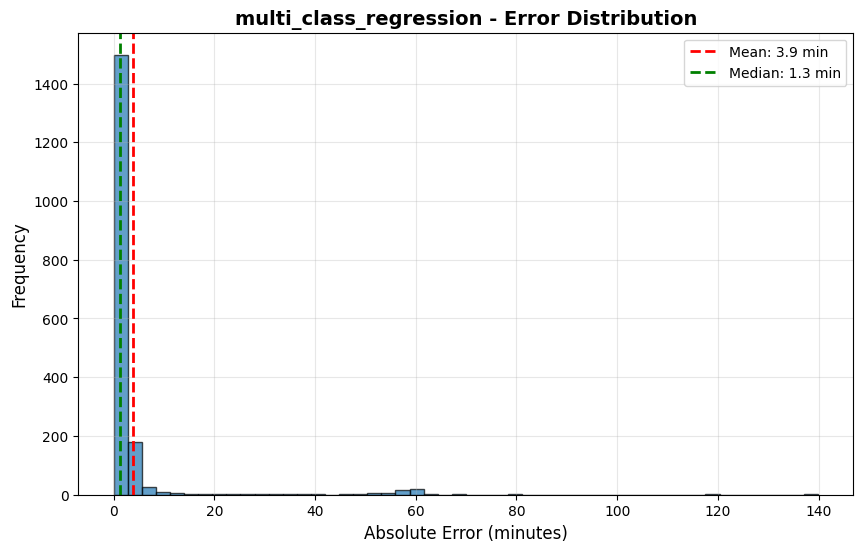

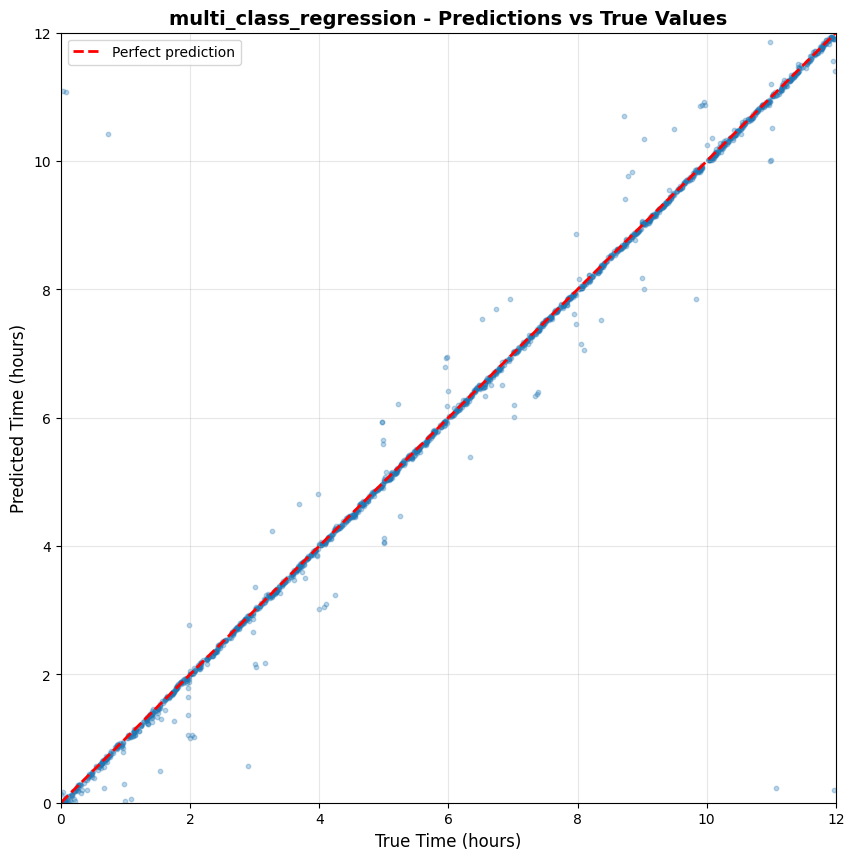

57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step

multi_regression_sin_cos - TEST SET RESULTS
Mean Absolute Error:    4.44 minutes
Median Absolute Error:  0.95 minutes
Std Deviation:          13.99 minutes
Max Error:              119.10 minutes

Accuracy within thresholds:
  Within 0 minutes:     0.0%
  Within 1 minute:      52.4%
  Within 5 minutes:     94.1%
  Within 10 minutes:    94.2%
  Within 15 minutes:    94.3%
  Within 30 minutes:    94.3%


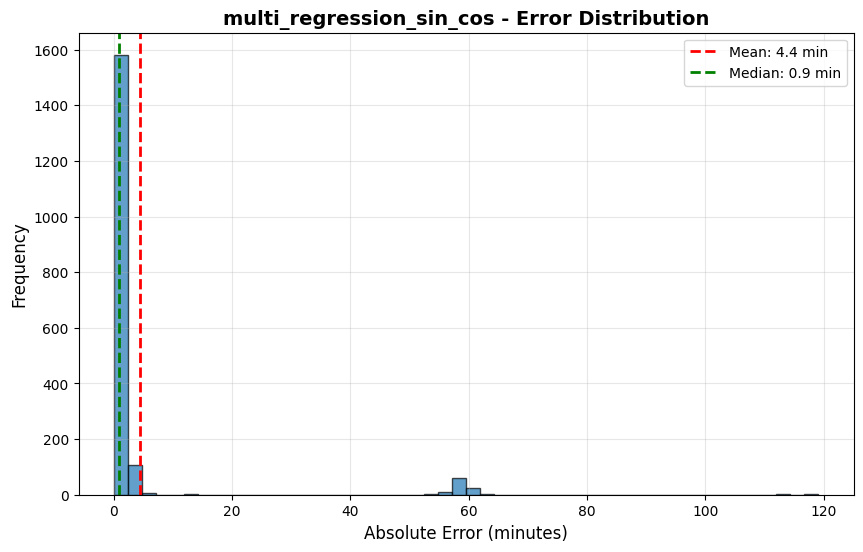

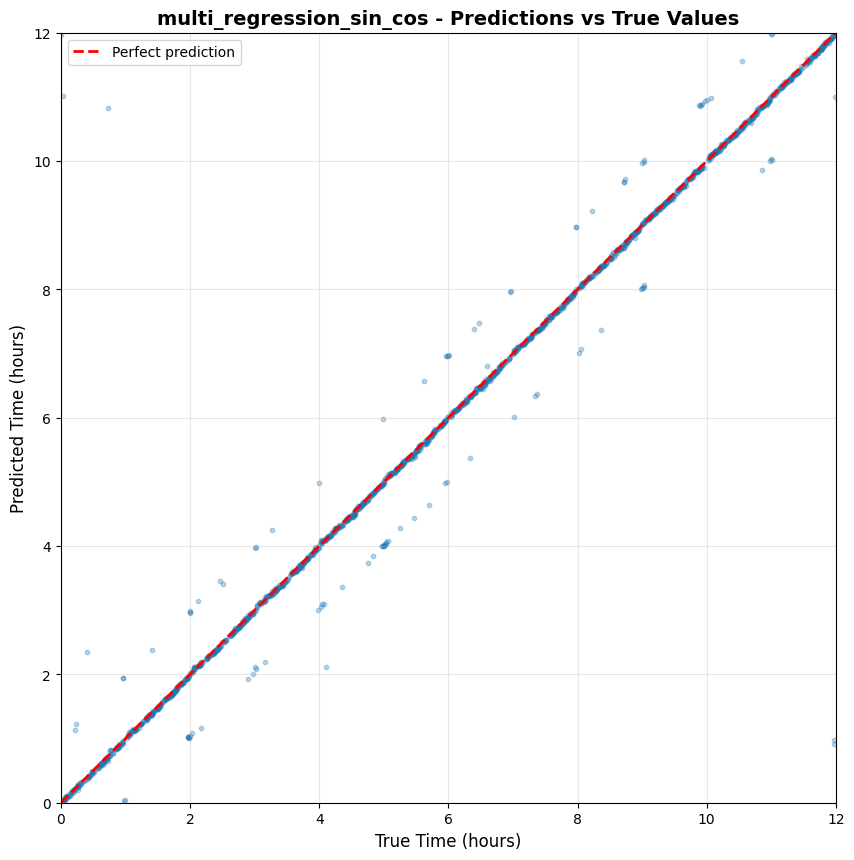

In [5]:
def plot_error_histogram(errors, model_name, save_path=None):
    """Plot histogram of prediction errors."""
    plt.figure(figsize=(10, 6))
    plt.hist(errors, bins=50, edgecolor='black', alpha=0.7)
    plt.xlabel('Absolute Error (minutes)', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.title(f'{model_name} - Error Distribution', fontsize=14, fontweight='bold')
    plt.axvline(np.mean(errors), color='r', linestyle='--', linewidth=2, label=f'Mean: {np.mean(errors):.1f} min')
    plt.axvline(np.median(errors), color='g', linestyle='--', linewidth=2, label=f'Median: {np.median(errors):.1f} min')
    plt.legend()
    plt.grid(True, alpha=0.3)
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def sin_cos_to_hours(sin_cos_predictions):
    """Convert [cos, sin] predictions back to hours (0-12)."""
    cos_vals = sin_cos_predictions[:, 0]
    sin_vals = sin_cos_predictions[:, 1]
    angles = np.arctan2(sin_vals, cos_vals)  # arctan2(sin, cos)
    angles = (angles % (2 * np.pi))  # ensure positive angles
    hours = angles * 12 / (2 * np.pi)  # convert to hours
    return hours

def sin_cos_to_minutes(sin_cos_predictions):
    """Convert [cos, sin] predictions back to minutes (0-59)."""
    cos_vals = sin_cos_predictions[:, 0]
    sin_vals = sin_cos_predictions[:, 1]
    angles = np.arctan2(sin_vals, cos_vals)  # arctan2(sin, cos)
    angles = (angles % (2 * np.pi))  # ensure positive angles
    minutes = angles * 59 / (2 * np.pi)  # convert to minutes
    return minutes

def plot_predictions_vs_true(pred, true, model_name, save_path=None):
    """Scatter plot of predictions vs true values."""
    # Scale back to original values and to decimal hours
    plt.figure(figsize=(10, 10))
    plt.scatter(true, pred, alpha=0.3, s=10)
    plt.plot([0, 12], [0, 12], 'r--', linewidth=2, label='Perfect prediction')
    plt.xlabel('True Time (hours)', fontsize=12)
    plt.ylabel('Predicted Time (hours)', fontsize=12)
    plt.title(f'{model_name} - Predictions vs True Values', fontsize=14, fontweight='bold')
    plt.xlim([0, 12])
    plt.ylim([0, 12])
    plt.legend()
    plt.grid(True, alpha=0.3)
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    
def get_hours_minutes(hours, minutes):
    """Convert one-hot or sin-cos encoded hours and minutes to numerical hours and minutes."""
    hours_ = hours
    if hours_.shape[1] == 12:
        hours_ = np.argmax(hours_, axis=1).reshape(-1, 1)

    minutes_ = minutes
    if minutes_.shape[1] == 2:
        minutes_ = sin_cos_to_minutes(minutes_).reshape(-1, 1)

    return hours_, minutes_

def to_decimal(y):
    """Convert split hours and minutes to decimal hours."""
    hours = y[0]
    minutes = y[1]
    hours, minutes = get_hours_minutes(hours, minutes)

    decimal_hours = hours + (minutes / 60)
    return decimal_hours

def split_to_diff_min(pred_time, true_time):
    """Calculate absolute difference in minutes between predicted and true times."""
    # if hours are one-hot encoded, convert to numerical
    hours: np.ndarray = pred_time[0]
    minutes: np.ndarray = pred_time[1]
    true_hours: np.ndarray = true_time[0]
    true_minutes: np.ndarray = true_time[1]
    hours, minutes = get_hours_minutes(hours, minutes)
    true_hours, true_minutes = get_hours_minutes(true_hours, true_minutes)

    # convert time to total minutes
    pred_total_min = (hours * 60) + minutes
    true_total_min = (true_hours * 60) + true_minutes

    # common sense loss in minutes
    diff_min = np.abs(pred_total_min - true_total_min)
    csl = np.minimum(diff_min, 720 - diff_min)

    return csl

def print_metrics(pred_time, true_time, model_name):
    """Print comprehensive evaluation metrics."""
    diff_min = split_to_diff_min(pred_time, true_time)

    mean_err = np.mean(diff_min)
    median_err = np.median(diff_min)
    std_err = np.std(diff_min)
    max_err = np.max(diff_min)
    
    within_0 = np.mean(diff_min <= 0) * 100
    within_1 = np.mean(diff_min <= 1) * 100
    within_5 = np.mean(diff_min <= 5) * 100
    within_10 = np.mean(diff_min <= 10) * 100
    within_15 = np.mean(diff_min <= 15) * 100
    within_30 = np.mean(diff_min <= 30) * 100
    
    print(f"\n{'=' * 80}")
    print(f"{model_name} - TEST SET RESULTS")
    print(f"{'=' * 80}")
    print(f"Mean Absolute Error:    {mean_err:.2f} minutes")
    print(f"Median Absolute Error:  {median_err:.2f} minutes")
    print(f"Std Deviation:          {std_err:.2f} minutes")
    print(f"Max Error:              {max_err:.2f} minutes")
    print(f"\nAccuracy within thresholds:")
    print(f"  Within 0 minutes:     {within_0:.1f}%")
    print(f"  Within 1 minute:      {within_1:.1f}%")
    print(f"  Within 5 minutes:     {within_5:.1f}%")
    print(f"  Within 10 minutes:    {within_10:.1f}%")
    print(f"  Within 15 minutes:    {within_15:.1f}%")
    print(f"  Within 30 minutes:    {within_30:.1f}%")
    
    return {
        'mean': mean_err,
        'median': median_err,
        'std': std_err,
        'max': max_err,
        'within_0': within_0,
        'within_1': within_1,
        'within_5': within_5,
        'within_10': within_10,
        'within_15': within_15,
        'within_30': within_30,
        'predictions': pred_time,
        'errors': diff_min
    }



if __name__ == "__main__":
    seed=42
    np.random.seed(seed)
    tf.random.set_seed(seed)
    keras.utils.set_random_seed(seed)

    dir = f"./images/multi"
    os.makedirs(dir, exist_ok=True)

    # load data
    X_train, y_train, X_val, y_val, X_test, y_test, _ = load_data(seed=42, easy=False)

    # split y_test into hours and mintes arrays
    y_test_split = list()
    y_test_split.append(y_test[:, 0].reshape(-1, 1))
    y_test_split.append(y_test[:, 1].reshape(-1, 1))

    # load model
    for curr_model in get_models():
        model_path = f"./saved_models/{curr_model}.keras"
        model = keras.models.load_model(model_path)

        # make predictions
        y_pred = model.predict(X_test)
        
        

        metrics = print_metrics(y_pred, y_test_split, curr_model)

        errors = metrics['errors']


        # convert split hours and minutes to decimal hours for plotting
        true_decimal = to_decimal(y_test_split)
        pred_decimal = to_decimal(y_pred)

        # plot error histogram
        plot_error_histogram(errors, model_name=curr_model, save_path=f"{dir}/{curr_model}_error_histogram.png")

        # plot predictions vs true values
        plot_predictions_vs_true(pred_decimal, true_decimal, model_name=curr_model, save_path=f"{dir}/{curr_model}_pred_vs_true.png")